In [1]:
from scipy.io import loadmat
from scipy.io import savemat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

import random
from tqdm import tqdm

%load_ext autoreload

In [9]:
%autoreload 2
from classes.fpst import *

In [12]:
if "google.colab" in sys.modules:
    root_dir = os.path.join(
        os.getcwd(), "drive", "MyDrive", "Colab Notebooks"
    )
    data_dir = os.path.join(root_dir, "data")
else:
    root_dir = os.getcwd()
    data_dir = os.path.join(root_dir, "data")

dir = os.path.join(data_dir, "SPST_perfect")

In [13]:
# Compute the FPST

file = loadmat(os.path.join(dir, "SPSTdata_2_pol-60.mat"))

maps = file["AcombineAll"][0]
X = file["Xnom_dumARRAY"][0]
Y = file["Ynom_dumARRAY"][0]

len_map = 26
len_map_big = 10

forbiden = [196, 197, 216, 217, 236, 237, 251, 255, 256, 262, 276, 277, 297, 317]
ind_forbiden = []

coords = []
for l in range(len(X)):
    # ignore the additional values in the center
    if X[l] not in forbiden and Y[l] not in forbiden:
        coords.append((X[l], Y[l]))
    else:
        ind_forbiden.append(l)

print("Overhead done, starting the loop", flush=True)

fpsts = get_maps(maps, coords, ind_forbiden, len_map, len_map_big)

Overhead done, starting the loop


Process: 100%|██████████| 100/100 [00:00<00:00, 153.58task/s]


C:\Users\f076048\AppData\Local\Temp\ipykernel_7500\2260434361.py:4: RuntimeWarning: divide by zero encountered in log10
  fpst = np.log10(np.abs(fpst))


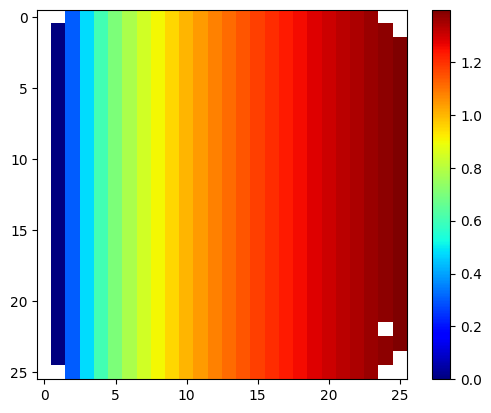

In [14]:
ind = random.randint(0, len(fpsts))

fpst = fpsts[ind]
fpst = np.log10(np.abs(fpst))

plt.imshow(fpst, cmap="jet")
plt.colorbar()
plt.show()

In [288]:
dict = {
    "fpsts": fpsts,
    "forbiden": forbiden,
    "coords": coords,
}
savemat(os.path.join(dir, "FPSTdata_2_pol-60.mat"), dict)

In [ ]:
# Test densification

ind = random.randint(0, len(fpsts))

fpst = fpsts[ind]

#map2 = densify_to(map, 26 * 2)

fpst2, orig = densify_to(fpst, 32, None)
""" map2, orig = densify_to(map2, 64, orig)
map2, orig = densify_to(map2, 128, orig)
map2, orig = densify_to(map2, 256, orig)

map3 = rev_densify_to(map2, 128)
map3 = rev_densify_to(map3, 64)
map3 = rev_densify_to(map3, 32) """
fpst3 = rev_densify_to(fpst2, 26)

""" for i in range(len(orig)):
    for j in range(len(orig)):
        map2[orig[i][j][0]][orig[i][j][1]] = 0 """

# compute the difference between the two maps
diff = np.sum(np.abs(fpst - fpst3), where=~np.isnan(fpst))
print(diff)

# plot the maps
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(fpst, cmap="jet")
axs[0].set_title("Original map")
# print the densified map with the original points red
axs[1].imshow(fpst2, cmap="jet")
axs[1].scatter(
    [orig[x][y][0] for x in range(len(orig)) for y in range(len(orig))],
    [orig[x][y][1] for x in range(len(orig)) for y in range(len(orig))],
    c="red",
    s=1,
    marker="s",
)
axs[1].set_title("Densified map")
axs[2].imshow(fpst3, cmap="jet")
axs[2].set_title("Reversed map")
plt.show()

In [ ]:
# Compute the FPSTs for the 3MI channels

len_map = 64
len_map_big = 512

grids = ["interpol_64", "interpol_128"]
channels = [[(2, -60), (2, 60), (2, 0), (3, -60), (4, -60)], [(2, -60), (2, 60), (3, -60)]]

for i in range(len(grids)):
    for j in range(len(channels[i])):
        path = os.path.join(data_dir, grids[i], "Maps_3MI" + str(channels[i][j][0]) + "_" + str(channels[i][j][1]))
        maps, coords = load_data(path, len_map_big)

        fpsts = get_maps(maps, coords, [], len_map, len_map_big)

        dir_path = os.path.join(data_dir, grids[i], "FPST_3MI" + str(channels[i][j][0]) + "_" + str(channels[i][j][1]))
        # create the directory if it doesn't exist
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        
        save_data(dir_path, fpsts, coords)
        print("Done with " + grids[i] + " " + str(channels[i][j][0]) + "_" + str(channels[i][j][1]))